In [43]:
%matplotlib inline

In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [45]:
# Read credit portfolio. Portfolio of loans to test
myPortfolio = pd.read_excel("OutstandingLoans.xlsx")

# Read historical loans

myLoanHistory = pd.read_excel("OldLoans.xlsx")

# Read economic and financial data from the Fed

FedHistory = pd.read_csv("Simplified_FedHistory.csv")


In [46]:
# YOB - 12 unique values, EAD - exposure at default, LGD - Loss given default

myPortfolio

,RiskLevel,YOB,LGD,EAD
0,1,1,0.25,21.627095
1,1,2,0.25,3.259451
2,1,3,0.25,20.390560
3,1,4,0.25,3.753431
4,1,5,0.25,5.719347
...,...,...,...,...
95,2,1,0.35,89.606570
96,2,2,0.35,7.515719
97,2,3,0.35,35.214424
98,2,4,0.35,6.476053


In [6]:
myLoanHistory

,ID,RiskLevel,YOB,Year,Default
0,1,3,1,2006,0
1,1,3,2,2007,0
2,1,3,3,2008,0
3,1,3,4,2009,0
4,1,3,5,2010,0
...,...,...,...,...,...
673926,59999,2,10,2015,0
673927,59999,2,11,2016,0
673928,59999,2,12,2017,0
673929,60000,1,1,2006,0


In [7]:
FedHistory

,Year,DJX_Return,GDP
0,2000,5.904783,2.910631
1,2001,-12.056505,0.189587
2,2002,-22.086291,2.042876
3,2003,29.449838,4.385583
4,2004,10.657407,3.123582
5,2005,4.568655,3.021188
6,2006,13.755301,2.409997
7,2007,3.784468,1.843589
8,2008,-38.613257,-2.768681
9,2009,25.703875,-0.233485


In [8]:
# Combine both datasets to get variables for historical values into 1 Data Frame

combinedHistory = pd.merge(myLoanHistory, FedHistory, on = "Year")

# Create model - Generalised Linear Model
# formula: Default stands for intercept (dependet vriable) 
# The intercept is the predicted value of the dependent variables 
# When all the independent variables /Risk level, YOB, DJX, GDP/ are 0. 

model = smf.glm(formula = "Default ~ RiskLevel + YOB + DJX_Return + GDP", 
                data = combinedHistory, 
                family = sm.families.Binomial())

# Fit the model

result = model.fit()

# Display and interpret results

print(result.summary())

# Estimated default probabilities

predictions = result.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:               673931
Model:                            GLM   Df Residuals:                   673926
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27334.
Date:                Mon, 10 Oct 2022   Deviance:                       54668.
Time:                        09:37:14   Pearson chi2:                 6.88e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7059      0.053    -89.531      0.0

In [9]:
# Calculate the Akaike criterion, the lower the AIC, the better the model fit
print(result.aic)

54677.994080961005


In [10]:
# Calculate the Bayesian information criterion, the lower the AIC, the better the model fit
print(result.bic)

-8990014.009832958


In [12]:
predictions

array([0.03133361, 0.0162271 , 0.008341  , ..., 0.00048924, 0.00024954,
       0.00048924])

In [13]:
# Compute historical portfolio default rates

Default = []
for i in range(np.shape(combinedHistory["YOB"].unique())[0]):
  YOB = combinedHistory.loc[combinedHistory["YOB"] == i + 1]
  DefaultFreq = YOB["Default"].value_counts()
  DefaultRate = (DefaultFreq.values[1]/(DefaultFreq.values[0] + DefaultFreq.values[1]))*100
  Default.append(DefaultRate)

# Dataframe containing years on books and predictive model probabilities

myModel = pd.DataFrame({"YOB": np.array(combinedHistory["YOB"]), "estDefault": predictions})

In [14]:
# Compute estimated default rates

estDefault = []
for i in range(np.shape(myModel["YOB"].unique())[0]):
  YOB = myModel.loc[myModel["YOB"] == i + 1]
  estDefaultFreq = YOB["estDefault"].mean()*100
  estDefault.append(estDefaultFreq)


In [23]:
# Adverse economic scenario - DJX and GDP totals per year
# Adverse scenario is the case when economy is contracting, it was the case of 2018, 2019 and 2020

AdverseScenario = pd.read_csv("Simplified_Adverse.csv")

# Portfolio under adverse economic conditions

AdversePortfolio = myPortfolio.assign(Year = AdverseScenario.iloc[0, 0], 
                                      DJX_Return = AdverseScenario.iloc[0, 1], 
                                      GDP = AdverseScenario.iloc[0, 2])

# Predicted default probabilities under adverse economic conditions. Using the created GLM.

PD = result.predict(AdversePortfolio)

# Dataframe containing years on books and predictive model probabilities 
# under adverse economic conditions. PD is calculated for each YOB, PD and myPortfolio are merged.
predPD = pd.DataFrame({"YOB": np.array(myPortfolio["YOB"]), "PD": PD})

In [16]:
AdverseScenario

,Year,DJX_Return,GDP
0,2018,-24.626893,-2.129263
1,2019,2.358807,0.793390
2,2020,18.992974,3.074821


In [39]:
combined = pd.concat([FedHistory, AdverseScenario])

In [40]:
combined

,Year,DJX_Return,GDP
0,2000,5.904783,2.910631
1,2001,-12.056505,0.189587
2,2002,-22.086291,2.042876
3,2003,29.449838,4.385583
4,2004,10.657407,3.123582
5,2005,4.568655,3.021188
6,2006,13.755301,2.409997
7,2007,3.784468,1.843589
8,2008,-38.613257,-2.768681
9,2009,25.703875,-0.233485


In [24]:
PD

0     0.020211
1     0.014833
2     0.010870
3     0.007958
4     0.005821
        ...   
95    0.038880
96    0.028680
97    0.021097
98    0.015487
99    0.011352
Length: 100, dtype: float64

In [22]:
predPD

,YOB,PD
0,1,0.020211
1,2,0.014833
2,3,0.010870
3,4,0.007958
4,5,0.005821
...,...,...
95,1,0.038880
96,2,0.028680
97,3,0.021097
98,4,0.015487


In [17]:
# Compute predicted default rates

predDefault = []
for i in range(np.shape(predPD["YOB"].unique())[0]):
  YOB = predPD.loc[predPD["YOB"] == i + 1]
  predDefaultFreq = YOB["PD"].mean()*100
  predDefault.append(predDefaultFreq)

# Compute the expected loss of the loan portfolio under adverse economic conditions

ExpectedLoss = sum(AdversePortfolio["EAD"]*AdversePortfolio["LGD"]*PD)

In [19]:
ExpectedLoss

23.28112208065946

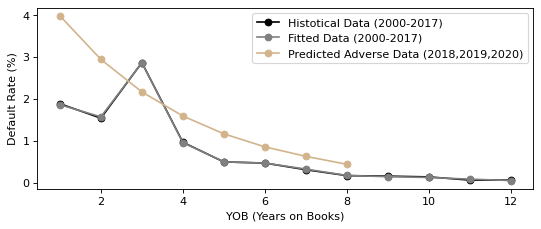

In [36]:
# Visualization with matplotlib
# If the YOB is the smallest / the most recent/, there is a high chance of high default
# Default rates are much higher in contracting economy (adverse) than in expanding economy (historical)
# Created GLM model is the very best fit for historical data, black line is fully covered by grey line 


from matplotlib.pyplot import figure
figure(figsize=(8, 3), dpi=80)

# original file, historical values, basis for GLM creation, train group, years until 2017, expanding economy
plt.plot(combinedHistory["YOB"].unique(), Default, "o-", color = "black", label = "Histotical Data (2000-2017)")
plt.ylabel("Default Rate (%)")
plt.legend()

# result of GLM prediction from historical data, similar to validation group, the GLM model is the best fit
plt.plot(myModel["YOB"].unique(), estDefault, "o-", color = "grey", label = "Fitted Data (2000-2017)")
plt.xlabel("YOB (Years on Books)")
plt.legend()

# result of prediction from adverse portfolio, similar to holdout, years 2018, 2019 and 2020, contracting economy
plt.plot(predPD["YOB"].unique(), predDefault, "o-", color = "tan", label = "Predicted Adverse Data (2018,2019,2020)")
plt.legend()

plt.show()